In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import StackingClassifier
import itertools
!pip install bioinfokit
from bioinfokit.visuz import cluster

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 84 kB 2.7 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56749 sha256=cb6fdfb421888de6569c2f10afe56ed9189d14ad2d18626873d0d098f19b0ed9
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=0bbfbcbcc9d965391f5043a6067c5bed8cb85b07956f865901f868a123a9133c
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


In [ ]:
# import dataset to classify pd and controls

path = r'/content/drive/MyDrive/Parkinson_prediction/Parkinson_controls.xls'
df = pd.read_excel(path,usecols=[0,2,4,5,12,14,15,16,17,18,19,20,21,22,23,24,25,26],index_col=0,na_values=['inf','NaN'])

# encode gender and group in binary format
df.replace(['male','female'],[1,0],inplace=True)
df.replace(['PD','CO'],[1,0],inplace=True)
df.dropna(inplace=True)

# set X and y by selecting a subset of features
'''selected_features = ['Speed_01 (m/sec)','sampen_3_025','dfa_4_12','Leg Imbalance','Gender','Age','cv_stride_times','no_strides']
y = df['Group'].values
X = df.loc[:,selected_features].values
X_scaled = MinMaxScaler().fit_transform(X)
column_names = df.loc[:,selected_features].columns'''

# set X and y by selecting all features
y = df['Group'].values
X = df.drop(['Group'],axis=1).values
X_scaled = MinMaxScaler().fit_transform(X)
column_names = df.drop(['Group'],axis=1).columns

# Set new X and new y after outlier removal using Isolation Forest algorithm
isofor = IsolationForest(contamination=0.1)
elenv = EllipticEnvelope(contamination=0.01)
one_cl_svm = OneClassSVM(nu=0.01)
y_hat = one_cl_svm.fit_predict(X)
mask = y_hat != -1
X_clean, y_clean = X[mask, :], y[mask]
X_cl_sc = MinMaxScaler().fit_transform(X_clean)

print(X.shape,X_clean.shape)

# print rows with existing nan values
print(df[df.isna().any(axis=1)])

# see target variable balance
print(df['Group'].value_counts())

(140, 16) (138, 16)
Empty DataFrame
Columns: [Group, Gender, Age, Speed_01 (m/sec), mean_stride_times, cv_stride_times, no_strides, dfa_4_8, dfa_4_10, dfa_4_12, dfa_4_14, sampen_2_020, sampen_2_025, sampen_2_030, sampen_3_025, sampen_3_030, Leg Imbalance]
Index: []
1    79
0    61
Name: Group, dtype: int64


## Principal component analysis for dimensionality reduction

In [ ]:
'''Construct Principal Components with PCA to reduce number of dimensions'''

pca = PCA(n_components=3)
pca.fit(X_scaled)
pca_features = pca.transform(X_scaled)
pca_df = pd.DataFrame(pca_features,columns=['PCA1','PCA2','PCA3'])
target_var = []
for i in y:
  if i == 0:
    target_var.append('Healthy')
  else:
    target_var.append('PD')
df_target_var = pd.DataFrame(target_var,columns=['Group'])
df_pca = pd.concat([pca_df,df_target_var],axis=1)
loading_scores = pca.components_
df_loadings = pd.DataFrame(loading_scores.T,columns=['PCA1','PCA2','PCA3'],index=column_names)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(np.round(explained_variance,decimals=2))
df_explained_var = pd.concat([pd.DataFrame(['PCA1','PCA2','PCA3'],columns=['PC']),
                              pd.DataFrame(explained_variance,columns=['Explained Variance']),
                              pd.DataFrame(cumulative_variance,columns=['Cumulative Variance'])],axis=1)
print(df_pca)

# Define new feature set, constructed by the 3 principal components derived from PCA
X_pca = df_pca.drop(['Group'],axis=1).values

         PCA1      PCA2      PCA3    Group
0   -0.419734  0.405059 -0.065535       PD
1    0.527664  0.517261  0.145485       PD
2   -0.487552  0.786735  0.037959       PD
3    0.572864  0.306531  0.156824       PD
4    0.554356  0.288342  0.129670       PD
..        ...       ...       ...      ...
135  0.705612  0.207443 -0.338857  Healthy
136  0.559586  0.304598  0.096958  Healthy
137 -0.328917 -0.027131 -0.299237  Healthy
138  0.517635 -0.175507  0.594509  Healthy
139 -0.192090 -0.449450 -0.622257  Healthy

[140 rows x 4 columns]


In [ ]:
# Scree Plot

fig = go.Figure()

fig.add_trace(go.Bar(x=df_explained_var['PC'],y=df_explained_var['Explained Variance'],marker=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=df_explained_var['PC'],y=df_explained_var['Cumulative Variance'],marker=dict(size=12,color='DarkViolet')))
fig.show()

In [ ]:
# PCA components 3d plot

fig = px.scatter_3d(df_pca,x='PCA1',y='PCA2',z='PCA3',color=df_pca['Group'])
fig.update_layout(template='plotly_dark')
fig.show()

In [ ]:
# Loading scores plot

loading_scores_labels = df_loadings.index
fig = px.scatter_3d(df_loadings,x='PCA1',y='PCA2',z='PCA3',text=loading_scores_labels)
fig.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


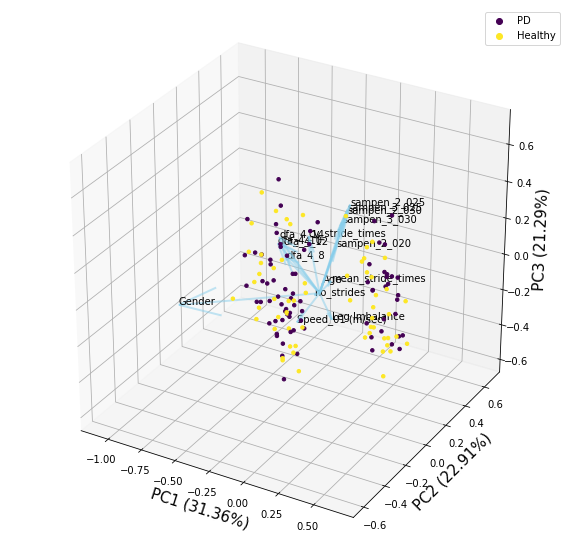

In [ ]:
'''PCA Biplot'''

cluster.biplot(cscore=pca_features,loadings=loading_scores,labels=loading_scores_labels,
                var1=np.round(df_explained_var['Explained Variance'][0]*100,2),
               var2=np.round(df_explained_var['Explained Variance'][1]*100,2),
               var3=np.round(df_explained_var['Explained Variance'][2]*100,2),
               show=True,colorlist=target_var,dim=(10,10),dotsize=12,arrowlinewidth=2,axlabelfontsize=15,
               valphaarrow=0.5)

In [ ]:
# check for multicollinearity

df_vif = pd.DataFrame()
df_vif["Feature"] = column_names
df_vif["VIF"] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
print(df_vif)

              Feature         VIF
0              Gender    2.907931
1                 Age   56.053349
2    Speed_01 (m/sec)   35.799848
3   mean_stride_times   67.101750
4     cv_stride_times   11.824731
5          no_strides   50.200160
6             dfa_4_8   16.730676
7            dfa_4_10   81.811054
8            dfa_4_12  141.104712
9            dfa_4_14  118.073430
10       sampen_2_020   25.938893
11       sampen_2_025  168.412120
12       sampen_2_030  169.635783
13       sampen_3_025  114.649356
14       sampen_3_030  120.915708
15      Leg Imbalance    2.323968


In [ ]:
# Set stratified cross validation, so that in each split test set it will contain the same number of fallers and non fallers
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=21)

In [ ]:
# Create a list of score results for each model

model_names = []
scores = []

In [ ]:
'''Random Forest Classifier'''

# create random forest model, fit data and crossvalidate to find best cost complexity parameter

rf = RandomForestClassifier()
gscv1 = GridSearchCV(rf,{"ccp_alpha":np.arange(0.025,1,0.025)},cv=cv)
gscv1.fit(X,y)
print("Best param is {}".format(gscv1.best_estimator_))
print("Best score is {}".format(gscv1.best_score_))

optimal_ccp_alpha = gscv1.best_params_['ccp_alpha']

tuned_rf = RandomForestClassifier(ccp_alpha=optimal_ccp_alpha)
cv1 = cross_val_score(tuned_rf,X,y,cv=cv)
model_names.append('Random Forest')
scores.append(cv1)
print(cv1)
print(np.mean(cv1))

Best param is RandomForestClassifier(ccp_alpha=0.07500000000000001)
Best score is 0.6428571428571429
[0.64285714 0.57142857 0.64285714 0.75       0.67857143]
0.6571428571428571


In [ ]:
'''AdaBoost'''

# create adaboost model, fit data and crossvalidate to find best learning rate

ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4))
gscv2 = GridSearchCV(ab,{"learning_rate":np.arange(0.01,1,0.01)},cv=cv)
gscv2.fit(X,y)
print("Best parameter is {}".format(gscv2.best_params_))
print("Best score is {}".format(gscv2.best_score_))

optimal_lr = gscv2.best_params_['learning_rate']

ab_tuned = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),learning_rate=optimal_lr)
cv2 = cross_val_score(ab_tuned,X,y,cv=cv)
model_names.append('Adaboost')
scores.append(cv2)
print(cv2)
print(np.mean(cv2))

Best parameter is {'learning_rate': 0.18000000000000002}
Best score is 0.6714285714285715
[0.71428571 0.53571429 0.64285714 0.75       0.71428571]
0.6714285714285715


In [ ]:
'''SVM'''

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
sv = SVC()
gscv3 = GridSearchCV(sv,param_grid,cv=cv)
gscv3.fit(X_scaled,y)
print("Best params are {}".format(gscv3.best_params_))
print("Best score is {}".format(gscv3.best_score_))

optimal_C = gscv3.best_params_['C']
optimal_gamma = gscv3.best_params_['gamma']
optimal_kernel = gscv3.best_params_['kernel']

tuned_sv = SVC(C=optimal_C, gamma=optimal_gamma, kernel=optimal_kernel)
cv3 = cross_val_score(tuned_sv,X_scaled,y,cv=cv)
model_names.append('Support Vector Machines')
scores.append(cv3)
print(cv3)
print(np.mean(cv3))

Best params are {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best score is 0.7
[0.75       0.64285714 0.75       0.67857143 0.67857143]
0.7


In [ ]:
'''Naive Bayes'''

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
gscv4 = GridSearchCV(nb,{'alpha':[ 0.0001,0.001,0.01,0.1,1,10,100,1000,10000]},cv=cv)
gscv4.fit(X,y)
print("Best parameter is {}".format(gscv4.best_params_))
print("Best score is {}".format(gscv4.best_score_))

optimal_alpha = gscv4.best_params_['alpha']

tuned_nb = MultinomialNB(alpha=optimal_alpha)
cv4 = cross_val_score(tuned_nb,X,y,cv=cv)
model_names.append('Naive Bayes')
scores.append(cv4)
print(cv4)
print(np.mean(cv4))

Best parameter is {'alpha': 0.0001}
Best score is 0.5785714285714285
[0.53571429 0.85714286 0.57142857 0.39285714 0.53571429]
0.5785714285714285


In [ ]:
'''KNN'''

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
gscv5 = GridSearchCV(knn,{'n_neighbors':np.arange(1,10,1)},cv=cv)
gscv5.fit(X_scaled,y)
print("Best parameter is {}".format(gscv5.best_params_))
print("Best score is {}".format(gscv5.best_score_))

optimal_n_neighbors = gscv5.best_params_['n_neighbors']

tuned_knn = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)
cv5 = cross_val_score(tuned_knn,X_scaled,y,cv=cv)
model_names.append('K Nearest Neighbors')
scores.append(cv5)
print(cv5)
print(np.mean(cv5))

Best parameter is {'n_neighbors': 7}
Best score is 0.6357142857142857
[0.78571429 0.53571429 0.67857143 0.64285714 0.53571429]
0.6357142857142857


In [ ]:
'''Logistic Regression'''

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

log_reg = LogisticRegression()
param_gr = {'penalty':['l1', 'l2', 'elasticnet', 'none'],'C':[0.001,0.01,0.1,1,10,100]}
gscv6 = GridSearchCV(log_reg,param_gr,cv=cv)
gscv6.fit(X,y)
print("Best parameter is {}".format(gscv6.best_params_))
print("Best score is {}".format(gscv6.best_score_))

opt_C = gscv6.best_params_['C']
opt_penalty = gscv6.best_params_['penalty']

tuned_log_reg = LogisticRegression(C=opt_C,penalty=opt_penalty)
cv6 = cross_val_score(tuned_log_reg,X,y,cv=cv)
model_names.append('Logistic Regression')
scores.append(cv6)
print(cv6)
print(np.mean(cv6))


Best parameter is {'C': 100, 'penalty': 'l2'}
Best score is 0.6357142857142858
[0.67857143 0.53571429 0.71428571 0.60714286 0.64285714]
0.6357142857142858


In [ ]:
''' Gradient Boosting Classifier'''

gb = GradientBoostingClassifier()
gscv7 = RandomizedSearchCV(gb,{"min_impurity_decrease":np.arange(0.01,1,0.01),'n_estimators':np.arange(10,300,10),'learning_rate':np.arange(0.01,1,0.01)},cv=cv)
gscv7.fit(X,y)
print("Best param is {}".format(gscv7.best_params_))
print("Best score is {}".format(gscv7.best_score_))

optimal_min_impurity_decrease = gscv7.best_params_['min_impurity_decrease']
optimal_n_estimators = gscv7.best_params_['n_estimators']
opt_lr = gscv7.best_params_['learning_rate']


tuned_gb = GradientBoostingClassifier(min_impurity_decrease=optimal_min_impurity_decrease,n_estimators=optimal_n_estimators,learning_rate=opt_lr)
cv7 = cross_val_score(tuned_gb,X,y,cv=cv)
model_names.append('Gradient Boosting')
scores.append(cv7)
print(cv7)
print(np.mean(cv7))

Best param is {'n_estimators': 20, 'min_impurity_decrease': 0.67, 'learning_rate': 0.16}
Best score is 0.6428571428571429
[0.71428571 0.60714286 0.67857143 0.53571429 0.64285714]
0.6357142857142857


In [ ]:
'''XGBoost'''

xgb = XGBClassifier()
gscv8 = RandomizedSearchCV(xgb,{"gamma":[0.01,0.1,1,10,50,100,1000],'n_estimators':np.arange(50,1000,50),'learning_rate':np.arange(0.01,1,0.01),
                                'eta':np.arange(0.1,1,0.1),'objective':['binary:logistic','reg:squarederror','multi:softprob','binary:hinge']},cv=cv)
gscv8.fit(X,y)
print("Best param is {}".format(gscv8.best_params_))
print("Best score is {}".format(gscv8.best_score_))

optimal_gamma = gscv8.best_params_['gamma']
optimal_n_est = gscv8.best_params_['n_estimators']
optim_lr = gscv8.best_params_['learning_rate']
optimal_eta = gscv8.best_params_['eta']
optimal_obj = gscv8.best_params_['objective']


tuned_xgb = XGBClassifier(gamma=optimal_gamma,n_estimators=optimal_n_est,learning_rate=optim_lr,eta=optimal_eta,objective=optimal_obj)
cv8 = cross_val_score(tuned_xgb,X,y,cv=cv)
model_names.append('XGBoost')
scores.append(cv8)
print(cv8)
print(np.mean(cv8))

Best param is {'objective': 'reg:squarederror', 'n_estimators': 450, 'learning_rate': 0.7100000000000001, 'gamma': 0.1, 'eta': 0.5}
Best score is 0.6785714285714285
[0.71428571 0.64285714 0.64285714 0.57142857 0.82142857]
0.6785714285714285


In [ ]:
'''Stacking'''
 
base_models = [('rf',tuned_rf),('lr',tuned_log_reg),('svm',tuned_sv),('naive_bayes',tuned_nb),('knn',tuned_knn),('xgb',tuned_xgb),('ab',ab_tuned)]
meta_learner = LogisticRegression()

stacking_model = StackingClassifier(estimators = base_models, final_estimator = meta_learner,cv = cv,passthrough=True)
cv9 = cross_val_score(stacking_model,X_scaled,y,cv=cv)
model_names.append('Stacking')
scores.append(cv9)
print(cv9)
print(np.mean(cv9))

[0.64285714 0.64285714 0.78571429 0.64285714 0.75      ]
0.6928571428571428


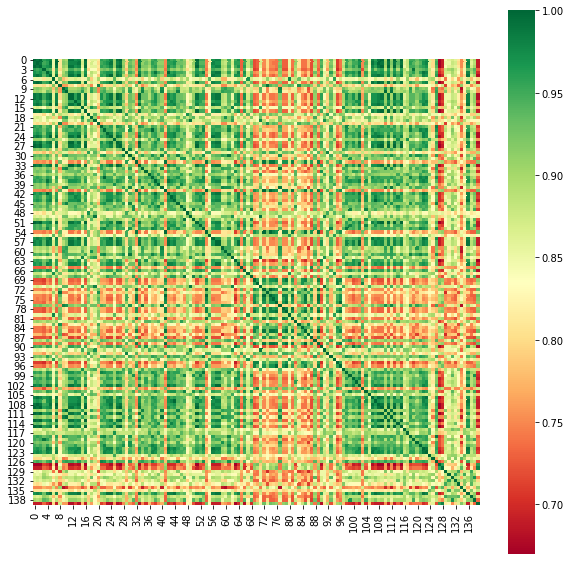

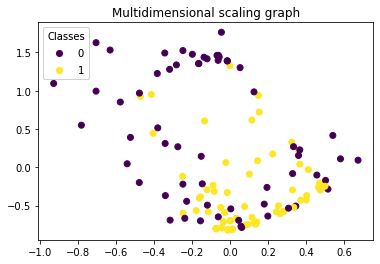

In [ ]:
'''Proximity Matrix Clustering and MDS'''

tuned_rf.fit(X,y)

#make proximity matrix to cluster subjects
def proximityMatrix(model, X, normalize=True):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

prox_matrix = proximityMatrix(tuned_rf, X, normalize=True)
#make a heatmap from proximity matrix to find subjects clustering together
plt.figure(figsize=[10,10])
sns.heatmap(prox_matrix,square=True,cmap="RdYlGn")
plt.show()

#make MDS plot with proximity matrix to find subjects clustering together
mds = MDS(n_components=2,random_state=0,metric=True)
mds_coordinates = mds.fit_transform(prox_matrix)

mds_df = pd.DataFrame(mds_coordinates,columns=["x","y"],index=df.index)
mds_df = pd.concat([mds_df,pd.Series(df['Group'])],axis=1)

fig, ax = plt.subplots()

scatter = ax.scatter(mds_df.x, mds_df.y,c=mds_df['Group'])
plt.title('Multidimensional scaling graph')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

#for sample in mds_df.index:
    #plt.annotate(sample,(mds_df.x.loc[sample],mds_df.y.loc[sample]))
plt.show()

In [ ]:
'''SVM on MDS features'''

X_mds = mds_df.drop(['Group'],axis=1).values
y_mds = mds_df['Group'].values

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
svm = SVC()
gscv10 = GridSearchCV(svm,param_grid,cv=cv)
gscv10.fit(X_mds,y_mds)
print("Best params are {}".format(gscv10.best_params_))
print("Best score is {}".format(gscv10.best_score_))

optimal_C = gscv10.best_params_['C']
optimal_gamma = gscv10.best_params_['gamma']
optimal_kernel = gscv10.best_params_['kernel']

tuned_sv = SVC(C=optimal_C, gamma=optimal_gamma, kernel=optimal_kernel)
cv10 = cross_val_score(tuned_sv,X_mds,y_mds,cv=cv)
model_names.append('SVM on MDS feats')
scores.append(cv10)
print(cv10)
print(np.mean(cv10))

Best params are {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score is 0.7357142857142858
[0.78571429 0.64285714 0.75       0.71428571 0.78571429]
0.7357142857142858


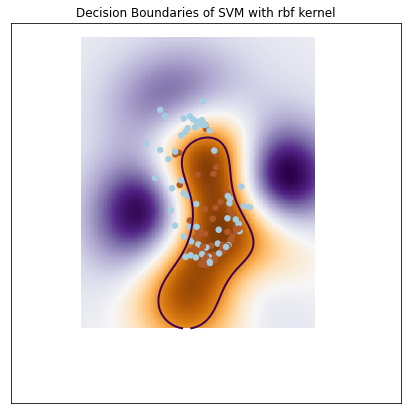

In [ ]:
'''Plot SVM decision boundaries on MDS features'''

def make_meshgrid(x, y, h=0.02):
    
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

xx, yy = make_meshgrid(X_mds[:,0],X_mds[:,1])

tuned_sv.fit(X_mds,y_mds)

# plot the decision function for each datapoint on the grid
Z = tuned_sv.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=[7,7])
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linetypes='--')
plt.scatter(X_mds[:, 0], X_mds[:, 1], s=30, c=y_mds, cmap=plt.cm.Paired)
plt.title(f'Decision Boundaries of SVM with {optimal_kernel} kernel')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

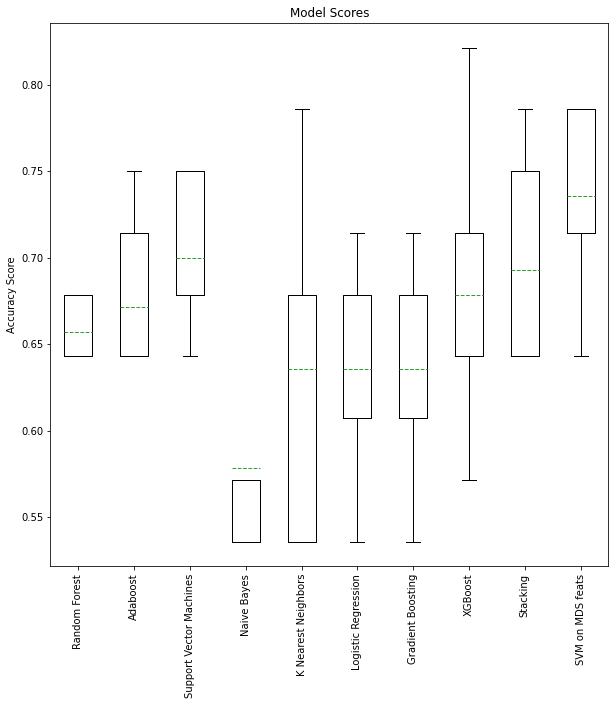

In [ ]:
# Plot Results
plt.figure(figsize=[10,10])
plt.title('Model Scores')
plt.ylabel('Accuracy Score')
plt.boxplot(scores,labels=model_names,showmeans=True,meanline=True,showfliers=False,medianprops =dict(linestyle='-.', linewidth=0, color='firebrick'))
plt.xticks(rotation=90)
plt.show()